<a href="https://colab.research.google.com/github/ZAsaee/Image_Segmentation-GastroIntestinal_Tract_Tumor_Detection/blob/main/Notebooks/2_Data_Visualization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **1. Import Packages**

In [1]:
import pandas as pd
import numpy as np
import os
import shutil
import zipfile
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
import imageio
from PIL import Image
import seaborn as sns
import cv2 as cv

sns.set_style('ticks')
sns.set_context('talk')

%matplotlib inline

In [3]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [4]:
# Mount the Google Drive
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [5]:
# Open the folder
%cd /content/gdrive/My Drive/'Springboard_DS_program'/'CP3_Prj'/'Data'

/content/gdrive/My Drive/Springboard_DS_program/CP3_Prj/Data


# **2. Load the Data**

In [6]:
# Read dataframes consisting of image information and segmentation
image_df = pd.read_csv('image_df.csv')

# On Kaggel page of competiton, it was explained that the first value of the image label is height and the second value is the width. I mislabeled them in the original DF. 
# I corrected it in the following dataframe.
image_df.columns = ['id', 'case', 'day', 'slice_id', 'size_y', 'size_x', 'spacing_y', 'spacing_x', 'class', 'segmentation']

image_df.head(10)

id     case    day    slice_id  size_y  size_x  \
0  case101_day20_slice_0066  case101  day20  slice_0066     266     266   
1  case101_day20_slice_0067  case101  day20  slice_0067     266     266   
2  case101_day20_slice_0068  case101  day20  slice_0068     266     266   
3  case101_day20_slice_0069  case101  day20  slice_0069     266     266   
4  case101_day20_slice_0070  case101  day20  slice_0070     266     266   
5  case101_day20_slice_0071  case101  day20  slice_0071     266     266   
6  case101_day20_slice_0072  case101  day20  slice_0072     266     266   
7  case101_day20_slice_0073  case101  day20  slice_0073     266     266   
8  case101_day20_slice_0074  case101  day20  slice_0074     266     266   
9  case101_day20_slice_0074  case101  day20  slice_0074     266     266   

   spacing_y  spacing_x        class  \
0        1.5        1.5      stomach   
1        1.5        1.5      stomach   
2        1.5        1.5      stomach   
3        1.5        1.5      stomach   
4        1.5        1.5      stomach   
5        1.5        1.5      stomach   
6        1.5        1.5      stomach   
7        1.5        1.5      stomach   
8        1.5        1.5  large_bowel   
9        1.5        1.5      stomach   

                                        segmentation  
0  32107 5 32371 10 32635 13 32900 15 33165 17 33...  
1  31313 2 31577 7 31841 10 32105 14 32369 17 326...  
2  30517 2 30781 6 31046 9 31311 11 31575 15 3184...  
3  29981 10 30246 13 30511 16 30776 19 31041 21 3...  
4  28918 9 29182 14 29446 18 29711 21 29976 23 30...  
5  28117 12 28382 16 28647 18 28912 21 29177 24 2...  
6  27053 9 27317 14 27582 16 27847 19 28112 22 28...  
7  26786 9 27050 14 27314 18 27579 21 27844 23 28...  
8  31080 6 31345 8 31610 10 31876 10 32142 10 324...  
9  26517 10 26781 16 27046 19 27311 22 27577 23 2...

# **3. Data Visualization**

## **3.1. Count Number of Cases for Each Tumor Types**

There are three classes of tumors in total: large bowel (large intestine), small bowel (small intestine) and stomach. These are three components of digestive system and responsible for breaking food down, absorbing the nutrients and solidifying the waste.
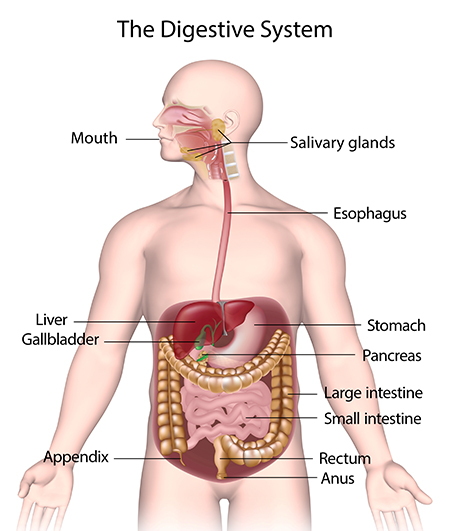

Ref.: https://www.niddk.nih.gov/health-information/digestive-diseases/digestive-system-how-it-works

In [7]:
image_df.groupby('class')['case'].count()

class
large_bowel    14085
small_bowel    11201
stomach         8627
Name: case, dtype: int64

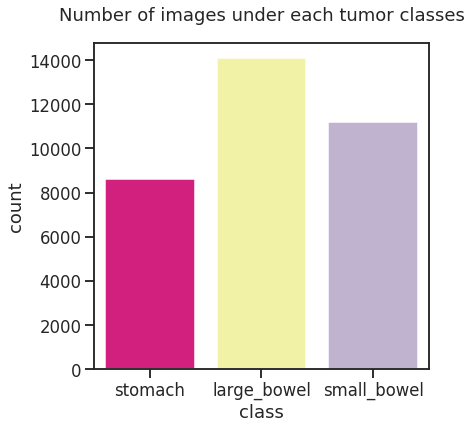

In [16]:
plt.figure(figsize=(6, 6))

sns.countplot(data=image_df, x='class', palette='Accent_r')
plt.title('Number of images under each tumor classes', y=1.05)
plt.show()

The largest number of cases belong to the large bowel class. It should be noted that a specific case may belong to more than one class. Therefore, I create a dataframe with unique ids to count the number of images under combined classes.

In [10]:
image_df_unique = image_df.drop_duplicates(subset=['id'], keep='first')

for i in range(image_df_unique.shape[0]):
  id = image_df_unique['id'].iloc[i]
  classes = image_df[image_df['id']==id]['class']
  segments = image_df[image_df['id']==id]['segmentation']
  image_df_unique['class'].iloc[i] = '+'.join(classes)
  image_df_unique['segmentation'].iloc[i] = '+'.join(segments)

image_df_unique.head(10)

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


id     case    day    slice_id  size_y  size_x  \
0   case101_day20_slice_0066  case101  day20  slice_0066     266     266   
1   case101_day20_slice_0067  case101  day20  slice_0067     266     266   
2   case101_day20_slice_0068  case101  day20  slice_0068     266     266   
3   case101_day20_slice_0069  case101  day20  slice_0069     266     266   
4   case101_day20_slice_0070  case101  day20  slice_0070     266     266   
5   case101_day20_slice_0071  case101  day20  slice_0071     266     266   
6   case101_day20_slice_0072  case101  day20  slice_0072     266     266   
7   case101_day20_slice_0073  case101  day20  slice_0073     266     266   
8   case101_day20_slice_0074  case101  day20  slice_0074     266     266   
10  case101_day20_slice_0075  case101  day20  slice_0075     266     266   

    spacing_y  spacing_x                class  \
0         1.5        1.5              stomach   
1         1.5        1.5              stomach   
2         1.5        1.5              stomach   
3         1.5        1.5              stomach   
4         1.5        1.5              stomach   
5         1.5        1.5              stomach   
6         1.5        1.5              stomach   
7         1.5        1.5              stomach   
8         1.5        1.5  large_bowel+stomach   
10        1.5        1.5  large_bowel+stomach   

                                         segmentation  
0   32107 5 32371 10 32635 13 32900 15 33165 17 33...  
1   31313 2 31577 7 31841 10 32105 14 32369 17 326...  
2   30517 2 30781 6 31046 9 31311 11 31575 15 3184...  
3   29981 10 30246 13 30511 16 30776 19 31041 21 3...  
4   28918 9 29182 14 29446 18 29711 21 29976 23 30...  
5   28117 12 28382 16 28647 18 28912 21 29177 24 2...  
6   27053 9 27317 14 27582 16 27847 19 28112 22 28...  
7   26786 9 27050 14 27314 18 27579 21 27844 23 28...  
8   31080 6 31345 8 31610 10 31876 10 32142 10 324...  
10  30813 7 31078 10 31343 11 31609 12 31875 12 32...

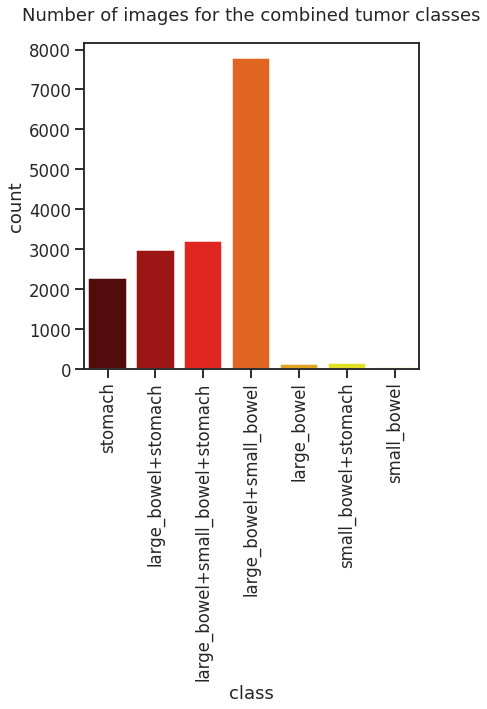

In [15]:
plt.figure(figsize=(6,6))

sns.countplot(data=image_df_unique, x='class', palette='hot')
plt.xticks(rotation=90)
plt.title('Number of images for the combined tumor classes', y=1.05)
plt.show()

The countplot shows that the largest number of images belong to the "large bowel plus small bowel" classes. Whereas the "small bowel", "large bowel" and "small bowel plus stomach" classes include the smallest number of cases.

## **3.2. Count Frequency of Images Based on the Cases and Days**

Let's check out the frequency of images based on the cases, days and slice numbers.

In [18]:
data_freq = image_df.groupby('id')[['case','day','slice_id']].first().reset_index()

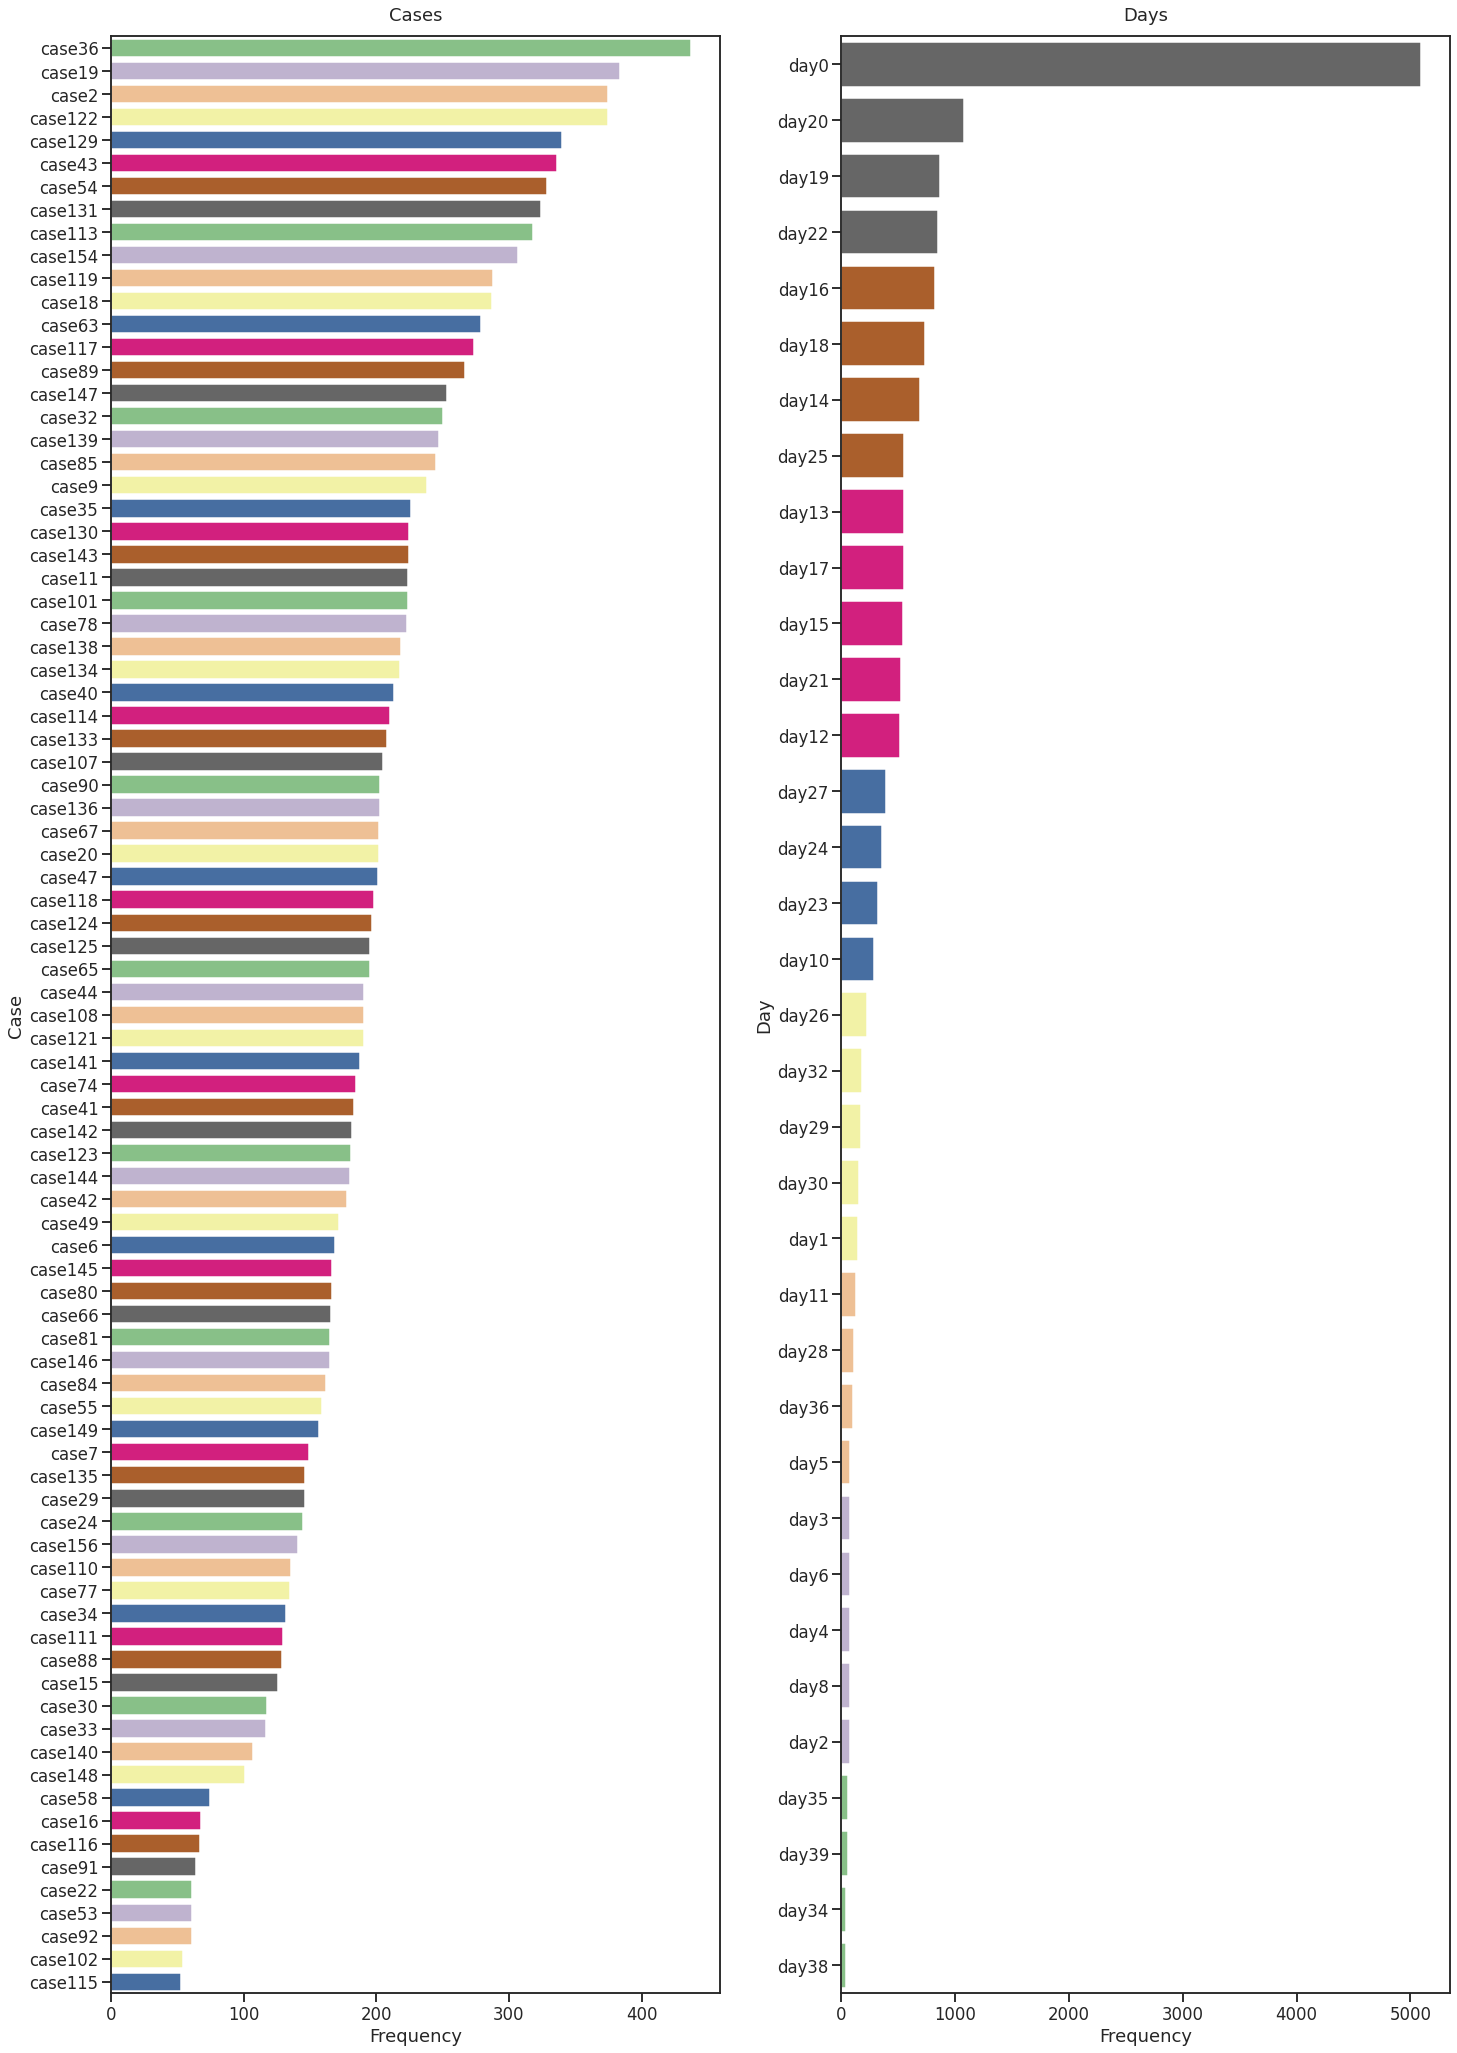

In [52]:
plt.figure(figsize=(24,36))
plt.subplot(1, 2, 1)
c = sns.barplot(data=data_freq['case'].value_counts().reset_index(), y='index', x='case', palette='Accent')
plt.title('Cases', y=1.005)
c.set_xlabel('Frequency')
c.set_ylabel('Case')

plt.subplot(1, 2, 2)
c = sns.barplot(data=data_freq['day'].value_counts().reset_index(), y='index', x='day', palette='Accent_r')
plt.title('Days', y=1.005)
c.set_xlabel('Frequency')
c.set_ylabel('Day')
plt.show()

Some of the cases have more than 400 data taken. Also, most of the cases have data taken on the first day. Afterwards, most of the data are taken between days 16 and 25.

## **3.3. Plot Images for Some of the Cases**

Let's plot the images for a couple of cases.

In [53]:
# Load and save the image files names
path = ''
image_dir = os.path.join('labeled_data')
image_list = os.listdir(image_dir)
image_files = [image_dir+ '/' + i for i in image_list]

In [54]:
image_df[image_df['case']=='case89'].sample(n=10)

id    case    day    slice_id  size_y  size_x  \
32572  case89_day19_slice_0083  case89  day19  slice_0083     360     310   
32386  case89_day17_slice_0055  case89  day17  slice_0055     360     310   
32682  case89_day20_slice_0082  case89  day20  slice_0082     266     266   
32378   case89_day0_slice_0119  case89   day0  slice_0119     360     310   
32672  case89_day20_slice_0079  case89  day20  slice_0079     266     266   
32596  case89_day19_slice_0091  case89  day19  slice_0091     360     310   
32634  case89_day20_slice_0063  case89  day20  slice_0063     266     266   
32432  case89_day17_slice_0075  case89  day17  slice_0075     360     310   
32643  case89_day20_slice_0068  case89  day20  slice_0068     266     266   
32562  case89_day19_slice_0079  case89  day19  slice_0079     360     310   

       spacing_y  spacing_x        class  \
32572        1.5        1.5  large_bowel   
32386        1.5        1.5  large_bowel   
32682        1.5        1.5      stomach   
32378        1.5        1.5  large_bowel   
32672        1.5        1.5  small_bowel   
32596        1.5        1.5  large_bowel   
32634        1.5        1.5      stomach   
32432        1.5        1.5  large_bowel   
32643        1.5        1.5  large_bowel   
32562        1.5        1.5      stomach   

                                            segmentation  
32572  31180 5 31539 8 31898 11 32258 13 32618 14 329...  
32386  33700 4 34059 8 34418 11 34778 12 35138 13 354...  
32682  20347 12 20610 19 20874 25 21139 27 21404 29 2...  
32378  45477 5 45836 9 46195 11 46554 13 46913 14 472...  
32672  23874 10 24137 15 24400 19 24663 24 24926 28 2...  
32596  29714 16 30074 20 30433 25 30741 4 30794 27 31...  
32634  28899 9 29163 12 29428 15 29693 17 29958 18 30...  
32432  33346 7 33706 9 34065 11 34425 12 34785 14 351...  
32643  18008 6 18274 8 18539 11 18805 12 19071 13 193...  
32562  36896 6 37254 10 37614 27 37974 34 38334 39 38...

### **3.3.1. Case 36**

Case 36 has the highest frequency.

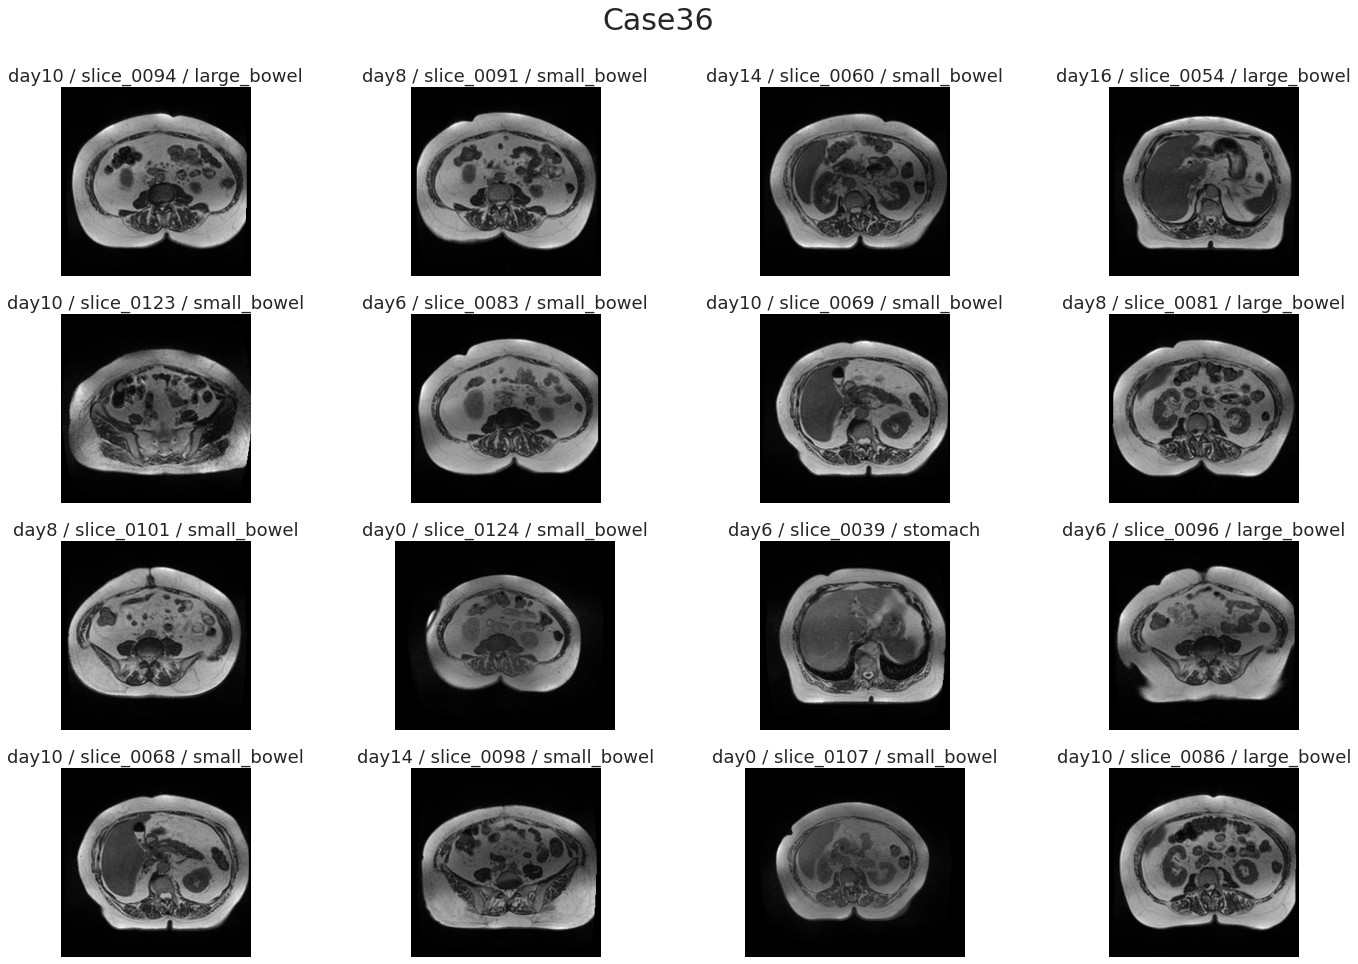

In [57]:
# Parameters for the graph: output images in 4x4 configuration
nrows = 4
ncols = 4

fig = plt.gcf()
fig.set_size_inches(nrows*6, ncols*4)
test_plot = image_df[image_df['case']=='case36'].sample(n=nrows*ncols)

for i in range(nrows * ncols):
  id = test_plot['id'].iloc[i]
  image_path = 'labeled_data'+'/'+id+'.png'
  img = imageio.imread(image_path)
  title = test_plot.iloc[i]['day'] + ' / ' + test_plot.iloc[i]['slice_id'] + ' / ' + test_plot.iloc[i]['class']
  
  sp = plt.subplot(nrows, ncols, i+1)
  sp.axis('off')
  plt.suptitle('Case36', fontsize=30, y=0.95)
  plt.title(title)
  plt.imshow(img, cmap='gray')

plt.show()

### **3.3.2. Case 115**

Case 115 has the lowest frequency.

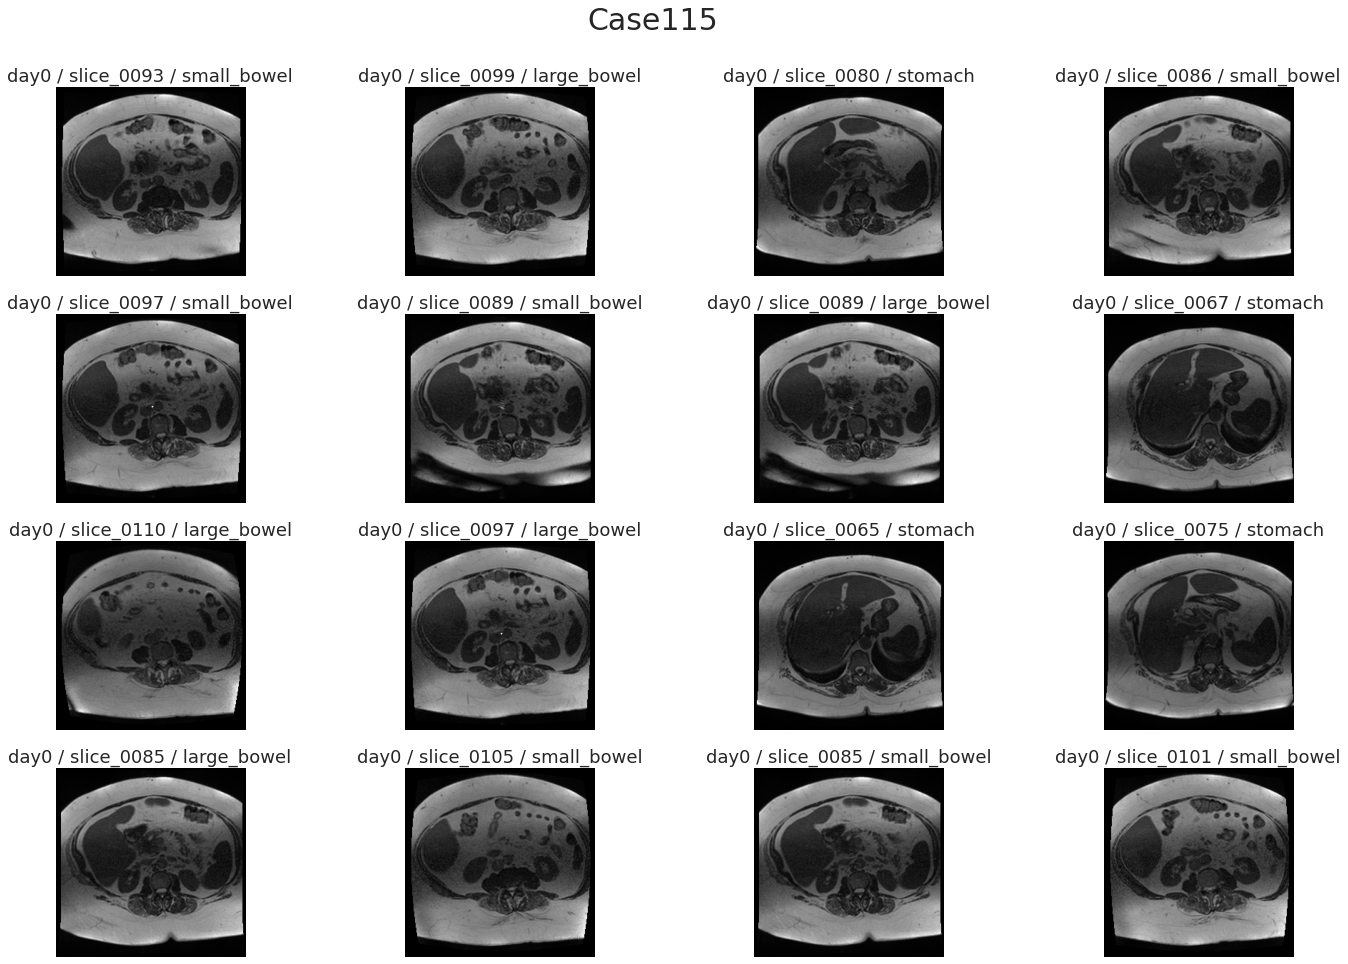

In [58]:
# Parameters for the graph: output images in 4x4 configuration
nrows = 4
ncols = 4

fig = plt.gcf()
fig.set_size_inches(nrows*6, ncols*4)
test_plot = image_df[image_df['case']=='case115'].sample(n=nrows*ncols)

for i in range(nrows * ncols):
  id = test_plot['id'].iloc[i]
  image_path = 'labeled_data'+'/'+id+'.png'
  img = imageio.imread(image_path)
  title = test_plot.iloc[i]['day'] + ' / ' + test_plot.iloc[i]['slice_id'] + ' / ' + test_plot.iloc[i]['class']
  
  sp = plt.subplot(nrows, ncols, i+1)
  sp.axis('off')
  plt.suptitle('Case115', fontsize=30, y=0.95)
  plt.title(title)
  plt.imshow(img, cmap='gray')

plt.show()

# **4. Convert RLE-encoding to mask image**

The annotation of images are provided by the RLE-encoding technique. I define a function to convert RLE to masked images. Each class of segmentation is specified with a different label and hence different color in the masked image.

In [59]:
# Define a function to encode RLE to mask image
def rle2mask(id):
  # unique image id
  classes = list(image_df[image_df.id == id]['class'])
  segments = list(image_df[image_df.id == id]['segmentation'])
  input_shape = (image_df[image_df.id == id]['size_x'].iloc[0], image_df[image_df.id == id]['size_y'].iloc[0])
  class_label ={'stomach':1, 'large_bowel':2, 'small_bowel':3}

  # Create a zero 2_d array with the image size
  mask_img = np.zeros(input_shape[0] * input_shape[1], dtype=np.uint8)
  
  for i in range(len(segments)):

    # Split the starts pixels and length and store in two arrays
    rle = segments[i]
    label = class_label[classes[i]]
    rle_lst = list(map(int, rle.split()))
    starts, lengths = [np.array(x) for x in (rle_lst[::2], rle_lst[1::2])]
    
    # deduct 1 from starts to match with the array index
    starts -= 1
    ends = starts + lengths

    for w, h in zip(starts, ends):
      mask_img[w:h] = label
    
  
  return mask_img.reshape(input_shape)

## **4.1. Masked Images of Case 19**

Let's look at some of the images and the corresponding masked images produced from RLE-encoding function.

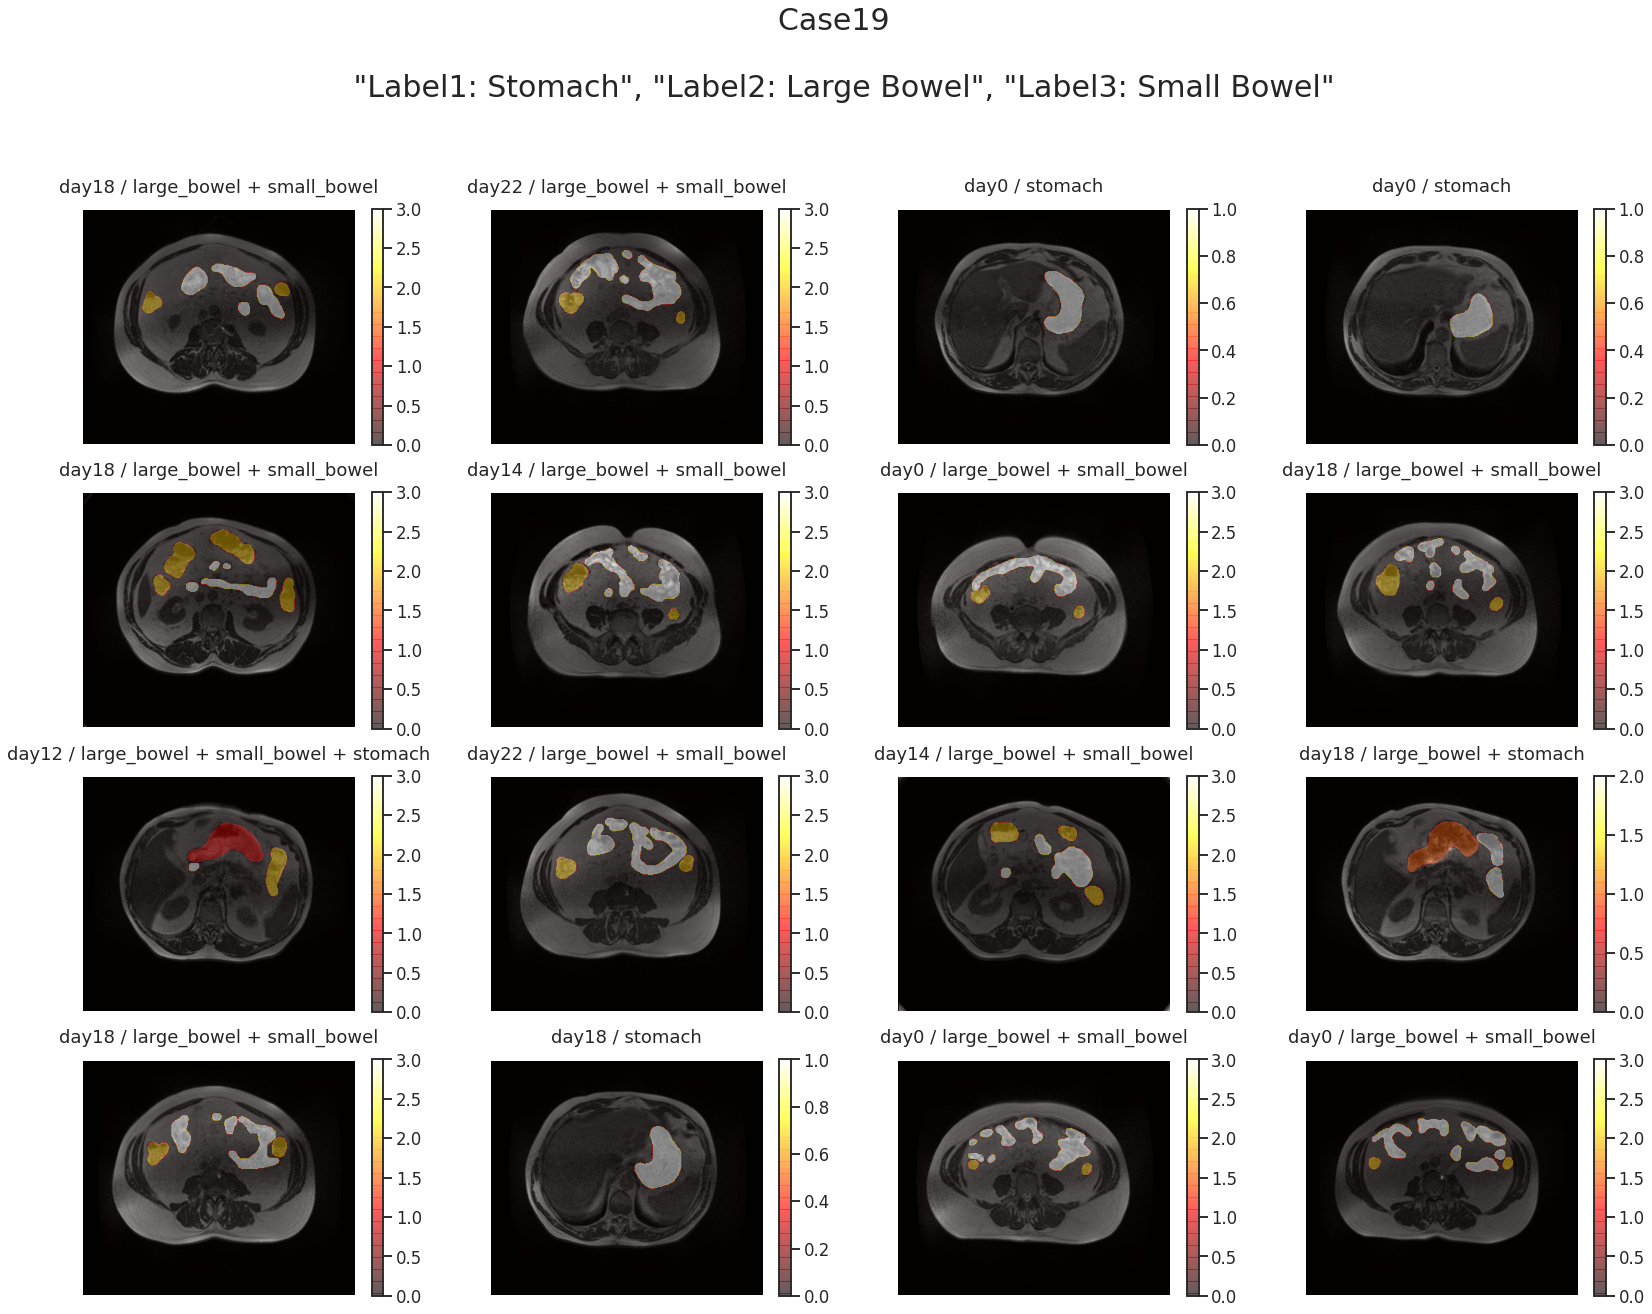

In [85]:
# Plot the masked images and the original ones

nrows = 4
ncols = 4

fig = plt.gcf()
fig.set_size_inches(nrows*7, ncols*5)
test_plot = image_df[image_df['case']=='case19'].sample(n=nrows*ncols)

for i in range(nrows * ncols):
  id = test_plot['id'].iloc[i]
  image_path = 'labeled_data'+'/'+id+'.png'
  img = imageio.imread(image_path)
  segments = test_plot.iloc[i]['day'] + ' / '+ ' + '.join(list(image_df[image_df['id']==id]['class']))
  title = segments 
  mask = rle2mask(id)
  
  sp = plt.subplot(nrows, ncols, i+1)
  sp.axis('off')
  plt.suptitle('Case19 \n \n "Label1: Stomach", "Label2: Large Bowel", "Label3: Small Bowel"', fontsize=30, y=1.02)
  plt.title(title, y=1.05)
  plt.imshow(img, cmap='gray')
  plt.imshow(mask, alpha=0.4, cmap='hot')
  plt.colorbar()

plt.show()

## **4.2. Masked Images of Case 102**

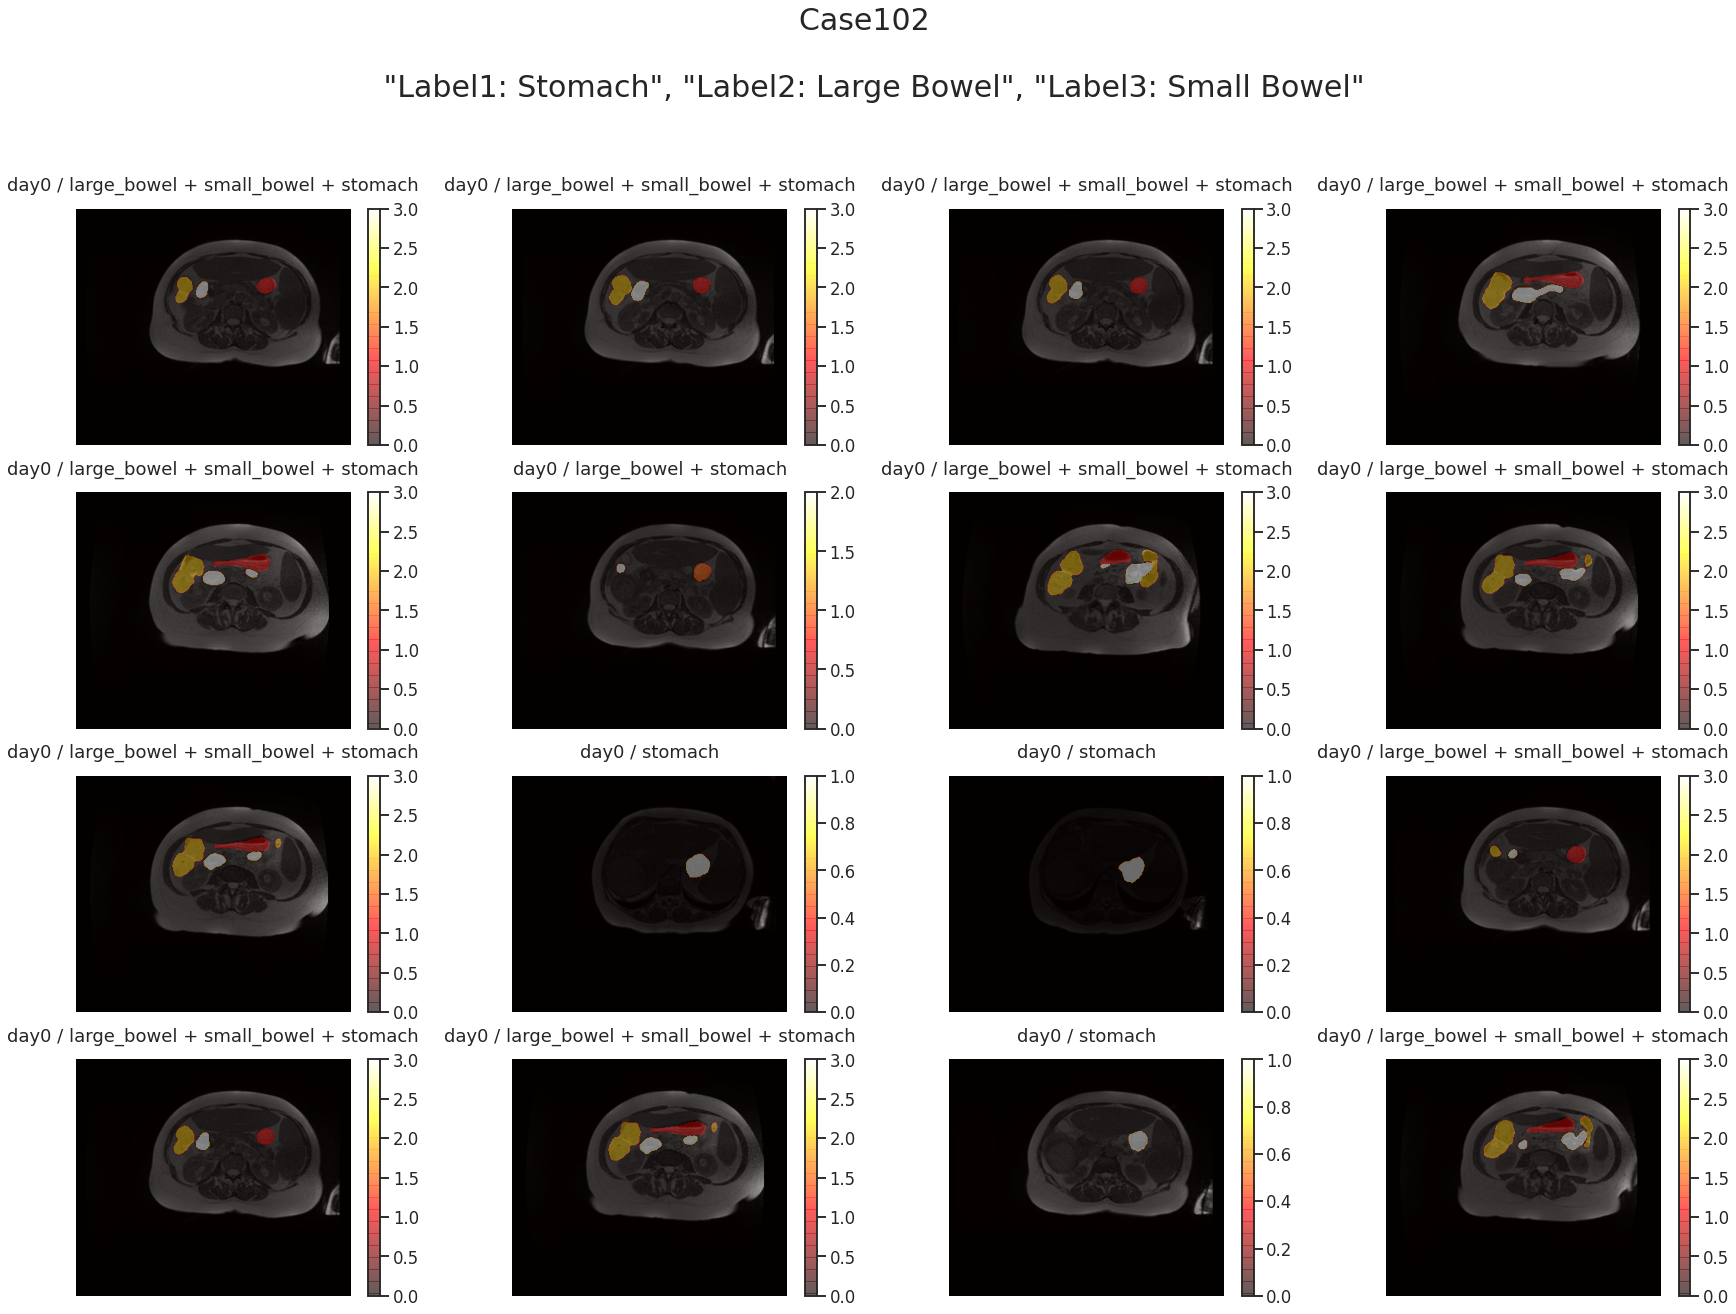

In [89]:
# Plot the masked images and the original ones

nrows = 4
ncols = 4

fig = plt.gcf()
fig.set_size_inches(nrows*7.5, ncols*5)
test_plot = image_df[image_df['case']=='case102'].sample(n=nrows*ncols)

for i in range(nrows * ncols):
  id = test_plot['id'].iloc[i]
  image_path = 'labeled_data'+'/'+id+'.png'
  img = imageio.imread(image_path)
  segments = test_plot.iloc[i]['day'] + ' / '+ ' + '.join(list(image_df[image_df['id']==id]['class']))
  title = segments 
  mask = rle2mask(id)
  
  sp = plt.subplot(nrows, ncols, i+1)
  sp.axis('off')
  plt.suptitle('Case102 \n \n "Label1: Stomach", "Label2: Large Bowel", "Label3: Small Bowel"', fontsize=30, y=1.02)
  plt.title(title, y=1.05)
  plt.imshow(img, cmap='gray')
  plt.imshow(mask, alpha=0.4, cmap='hot')
  plt.colorbar()

plt.show()

## **4.3. Save the masked images in a seperate folder**

I create a new folder to save the masked images and images. Then, I created masked images using rle2mask function.

In [ ]:
## Create folders to save images and masked images
# !mkdir 'cleaned_data'
# !mkdir 'cleaned_data/masks'
# !mkdir 'cleaned_data/images'

In [ ]:
# # Save the images and the corresponding masked images in the processed_data

# for i in range(image_df_unique.shape[0]):
#   # read the id from image_df dataframe
#   id = image_df_unique.id.iloc[i]

#   # Find the corresponding image
#   img_id = 'labeled_data/'+id+'.png'
#   img = imageio.imread(img_id)
#   mask = rle2mask(id)

#   # Save image and its mask

#   Image.fromarray(img).save('data_images_masked/images/'+id+'.png')
#   Image.fromarray(mask).save('data_images_masked/masks/'+id+'.png')

In [91]:
# Check the number of images in each folder

image_folder = os.path.join('cleaned_data/images/')
image_files_list = os.listdir(image_folder)

In [93]:

mask_folder = os.path.join('cleaned_data/masks')
mask_files_list = os.listdir(mask_folder)

In [94]:
print(f'number of images: {len(image_files_list)}')
print(f'number of masked images: {len(mask_files_list)}')

number of images: 16590
number of masked images: 16590


# **5. Crop Images**

In [95]:
# Define the function to crop images
def crop_image_border(img, mask, tol=0):
  '''
    crops the black border of images
    img: unmasked image
    mask: masked image
    tol: pixel tolerance for cropping images

    return: cropped unmasked and masked image

  '''

  row_start_general  = 10000
  col_start_general = 10000
  row_end_general = 0
  col_end_general = 0

  img = np.array(img, dtype=int)
  mask = np.array(mask, dtype=int)

  img_max = np.max(img)
  img = img / img_max

  mask_max = np.max(mask)
  mask = mask / mask_max

  border = img > tol

  if img.ndim == 3:
    border = border.all(2)

  m,n = border.shape
  border0, border1 = border.any(0), border.any(1)
  col_start, col_end = border0.argmax(), n-border0[::-1].argmax()
  row_start, row_end = border1.argmax(), m-border1[::-1].argmax()

  row_start_general = min(row_start, row_start_general)
  row_end_general = max(row_end, row_end_general)

  col_start_general = min(col_start, col_start_general)
  col_end_general = max(col_end, col_end_general)

  cropped_img = img[row_start_general:row_end_general, col_start_general:col_end_general]
  cropped_mask = mask[row_start_general:row_end_general, col_start_general:col_end_general]

  return cropped_img, cropped_mask

Prior to cropping the images, let's check the function and its output.

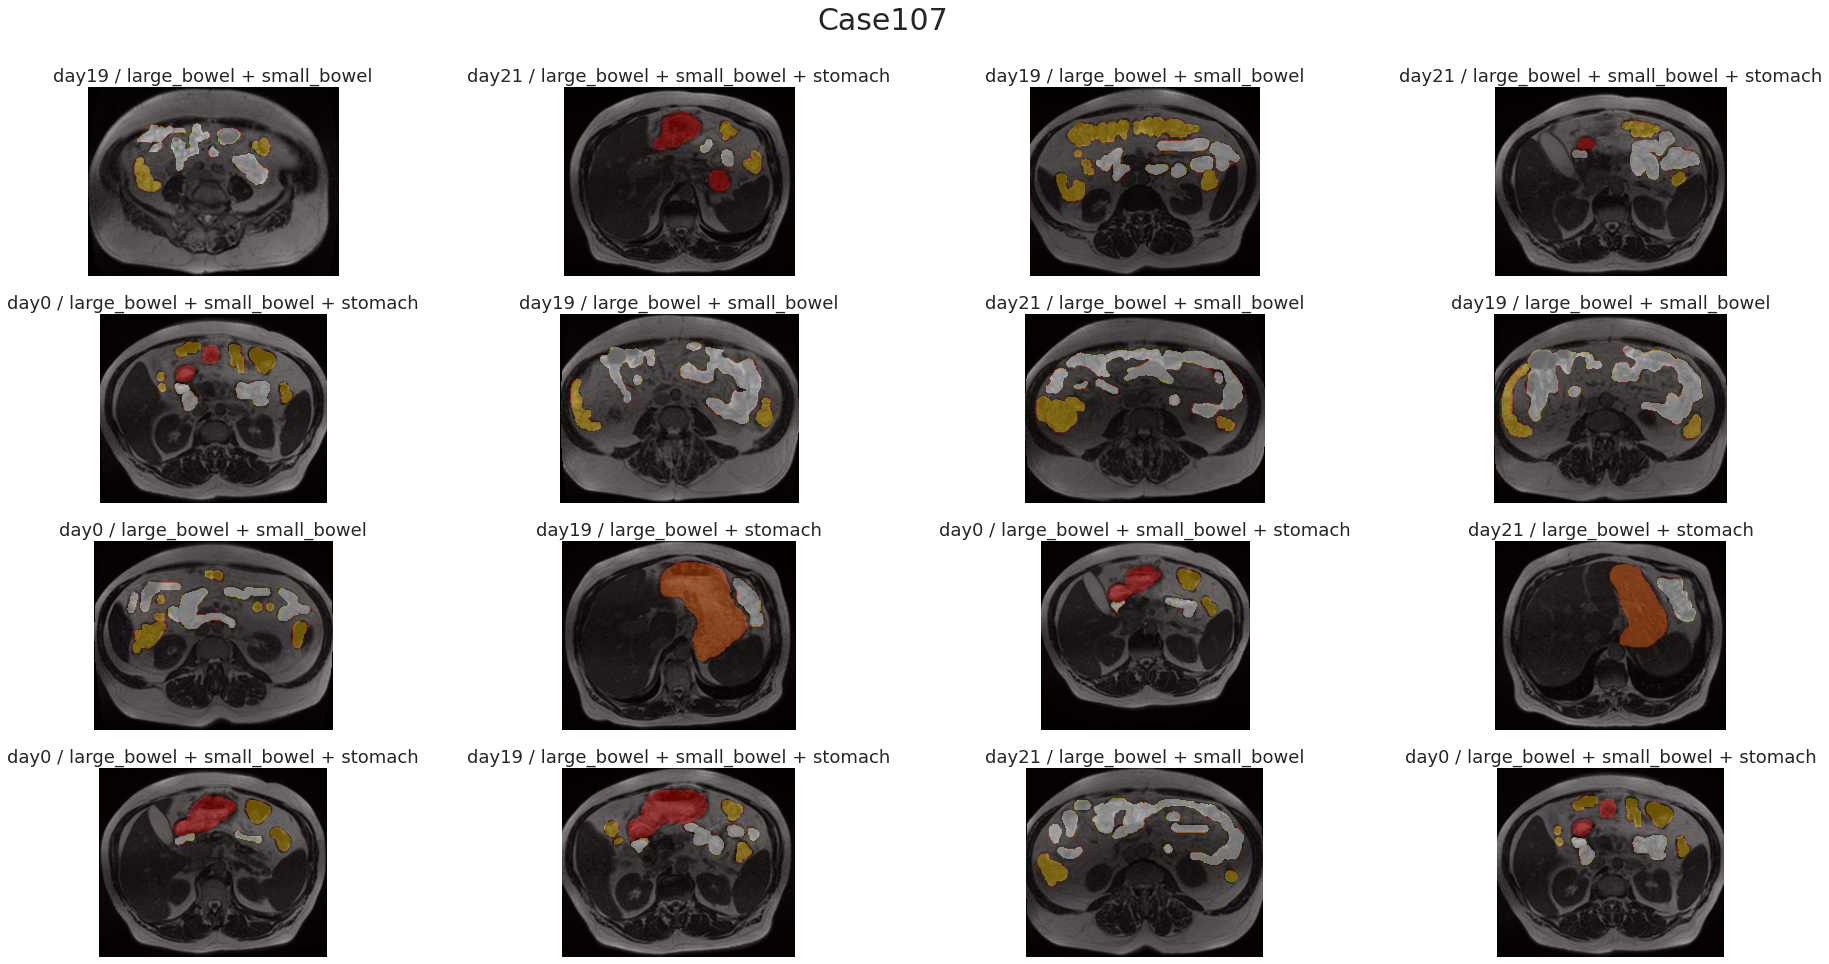

In [ ]:
# Check out the crop function outputs

nrows = 4
ncols = 4

fig = plt.gcf()
fig.set_size_inches(nrows*8, ncols*4)
test_plot = image_df[image_df['case']=='case107'].sample(n=nrows*ncols)

for i in range(nrows * ncols):
  id = test_plot['id'].iloc[i]
  image_path = 'cleaned_data/images'+'/'+id+'.png'
  mask_path = 'cleaned_data/masks'+'/'+id+'.png'
  img = imageio.imread(image_path)
  mask = imageio.imread(mask_path)
  segments = test_plot.iloc[i]['day'] + ' / '+ ' + '.join(list(image_df[image_df['id']==id]['class']))
  title = segments 
  img, mask = crop_image_border(img, mask, tol=0.05)
  
  sp = plt.subplot(nrows, ncols, i+1)
  sp.axis('off')
  plt.suptitle('Case107', fontsize=30, y=0.95)
  plt.title(title)
  plt.imshow(img, cmap='gray')
  plt.imshow(mask, alpha=0.4, cmap='hot')

plt.show()

Now, I crop all unmasked and masked images and save those in seperate folders.

In [ ]:
# # Make directories to save cropped images and masks
# !mkdir 'cleaned_data/cropped_masks'
# !mkdir 'cleaned_data/cropped_images'

In [ ]:
# for i in range(image_df_unique.shape[0]):
#   # read the id from image_df dataframe
#   id = image_df_unique.id.iloc[i]

#   # Find the corresponding image
#   img_id = 'cleaned_data/images/'+id+'.png'
#   mask_id = 'cleaned_data/masks/'+id+'.png'
#   img = imageio.imread(img_id)
#   mask = imageio.imread(mask_id)

#   cropped_img, cropped_mask = crop_image_border(img, mask, tol=0.05)

#   # Save image and its mask
#   cropped_image = Image.fromarray(np.uint8(cropped_img * 255)).convert('RGB').save('cleaned_data/cropped_images/'+id+'.png')
#   cropped_mask = Image.fromarray(np.uint8(cropped_mask * 255)).convert('RGB').save('cleaned_data/cropped_masks/'+id+'.png')